In [1]:
%matplotlib inline


Regions extraction using Dictionary Learning and functional connectomes
=======================================================================

This example shows how to use `nilearn.regions.RegionExtractor`
to extract spatially constrained brain regions from whole brain maps decomposed
using dictionary learning and use them to build a functional connectome.

We used 20 resting state ADHD functional datasets from `nilearn.datasets.fetch_adhd`
and `nilearn.decomposition.DictLearning` for set of brain atlas maps.

This example can also be adapted to apply the same steps to even regions extraction
using ICA maps. In that case, idea would be to replace dictionary learning to canonical
ICA decomposition using `nilearn.decomposition.CanICA`

Fetch ADHD resting state functional datasets
---------------------------------------------

We use nilearn's datasets downloading utilities



In [2]:
from nilearn import datasets

adhd_dataset = datasets.fetch_adhd(n_subjects=20)
func_filenames = adhd_dataset.func
confounds = adhd_dataset.confounds

/home/varoquau/dev/nilearn/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


Extract resting-state networks with DictionaryLearning
-------------------------------------------------------



In [3]:
# Import dictionary learning algorithm from decomposition module and call the
# object and fit the model to the functional datasets
from nilearn.decomposition import DictLearning

# Initialize DictLearning object
dict_learn = DictLearning(n_components=5, smoothing_fwhm=6.,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0, verbose=2)
# Fit to the data
dict_learn.fit(func_filenames)
# Resting state networks/maps in attribute `components_img_`
# Note that this attribute is implemented from version 0.4.1.
# For older versions, see the note section above for details.
components_img = dict_learn.components_img_

[MultiNiftiMasker.fit] Loading data from [/home/varoquau/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz, /home/varoquau/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz, /home/varoquau/nilearn_
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[DictLearning] Loading data
[DictLearning] Learning initial components
[Memory]    0.0s, 0.0min: Loading randomized_svd...
[Memory]    0.1s, 0.0min: Loading fastica...
[DictLearning] Computing initial loadings
[Memory]    0.0s, 0.0min: Loading _compute_loadings...
[DictLearning] Learning dictionary


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


________________________________________________________________________________
[Memory] Calling sklearn.decomposition.dict_learning.dict_learning_online...
dict_learning_online(array([[ 3.519859, ...,  0.205372],
       ...,
       [ 3.338944, ..., -1.447896]], dtype=float32), 
5, alpha=10, n_iter=3205, batch_size=20, method='cd', dict_init=array([[ 0.127084, ..., -0.377782],
       ...,
       [-0.926645, ..., -0.174996]], dtype=float32), verbose=1, random_state=0, return_code=True, shuffle=True, n_jobs=1)
[dict_learning] .....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Show networks using plotting utilities

/usr/lib/python3/dist-packages/matplotlib/contour.py:909: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


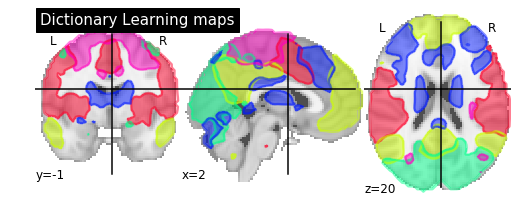

In [4]:
# Visualization of resting state networks
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='Dictionary Learning maps')

Show all the maps

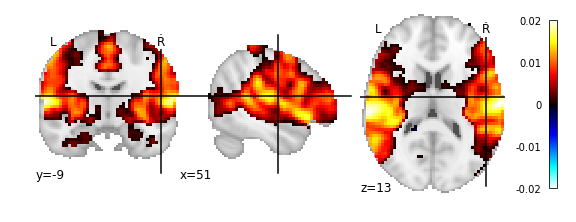

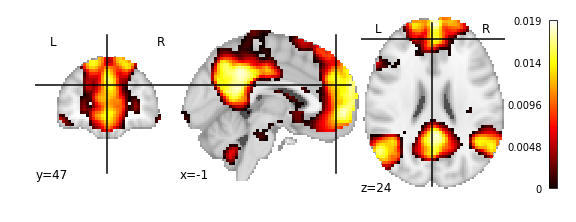

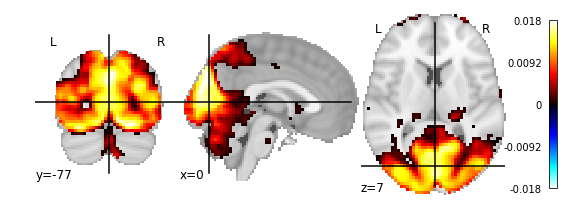

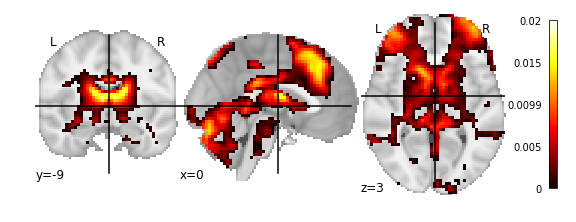

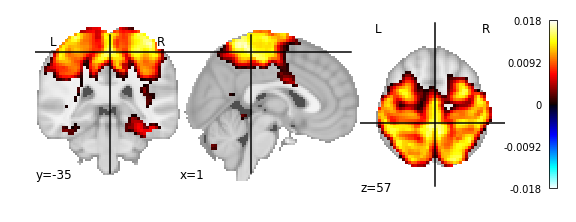

In [5]:
from nilearn import image
for network_img in image.iter_img(components_img):
    plotting.plot_stat_map(network_img)

Extract regions from networks
------------------------------



In [6]:
# Import Region Extractor algorithm from regions module
# threshold=0.5 indicates that we keep nominal of amount nonzero voxels across all
# maps, less the threshold means that more intense non-voxels will be survived.
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

Visualization of region extraction results

/usr/lib/python3/dist-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/lib/python3/dist-packages/matplotlib/contour.py:909: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home/varoquau/.local/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


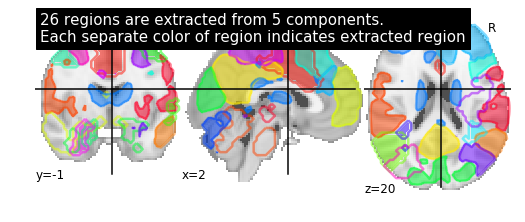

In [7]:
title = ('%d regions are extracted from %d components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 5))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

Plot each region

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


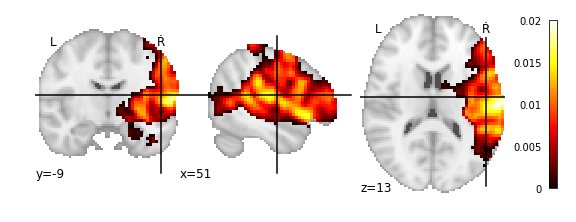

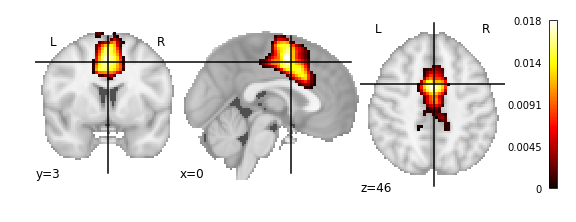

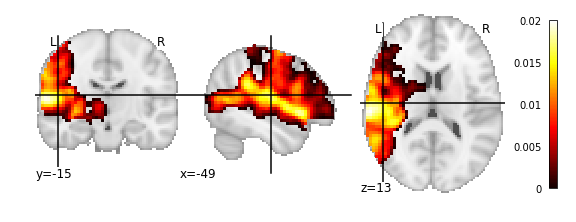

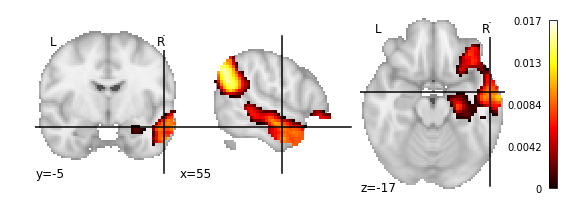

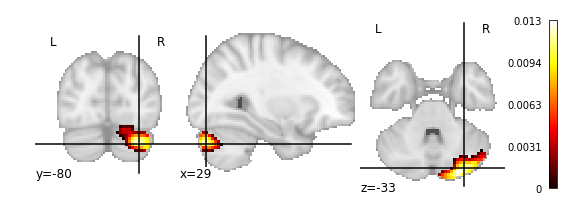

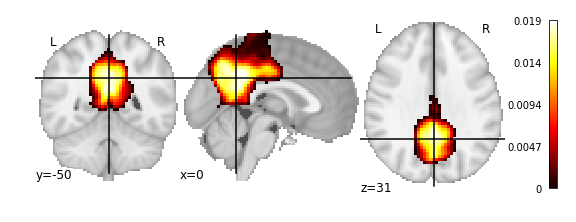

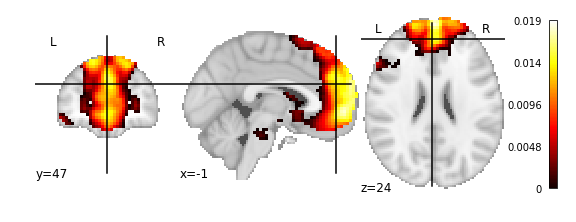

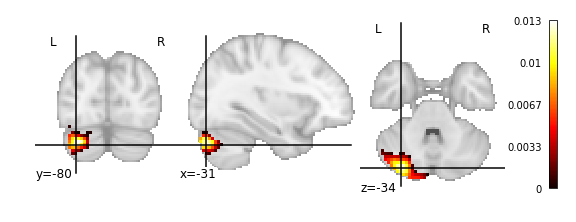

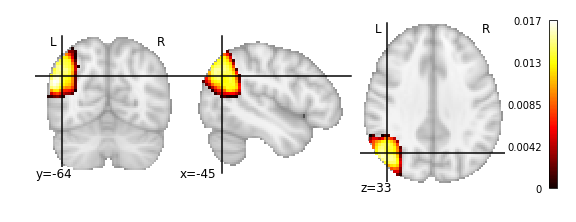

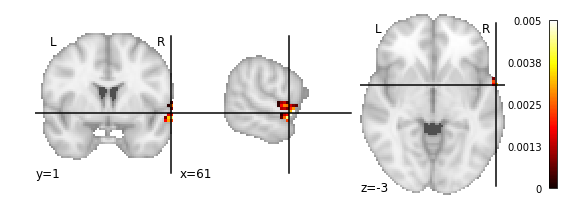

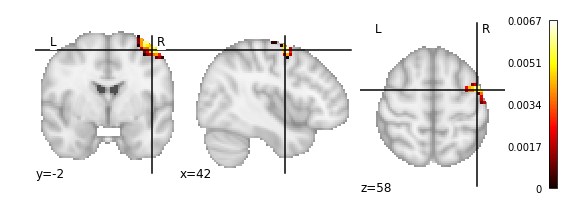

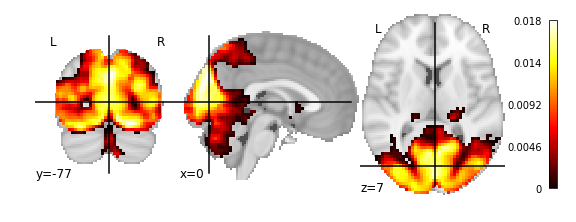

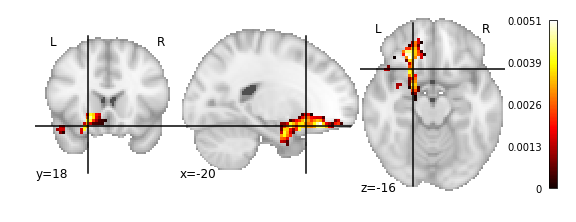

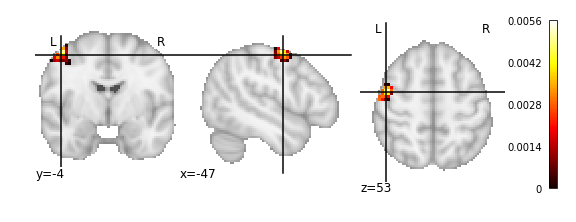

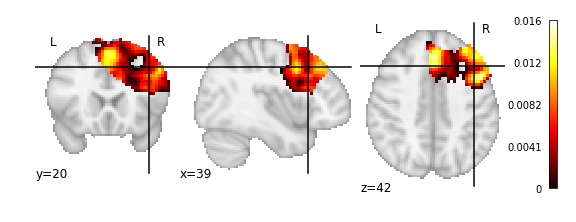

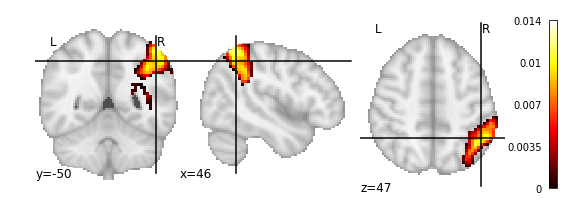

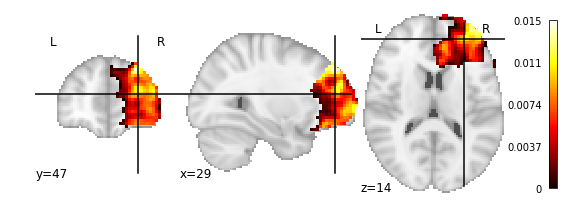

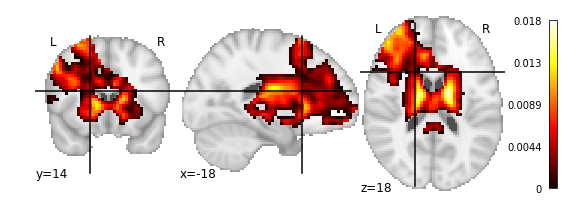

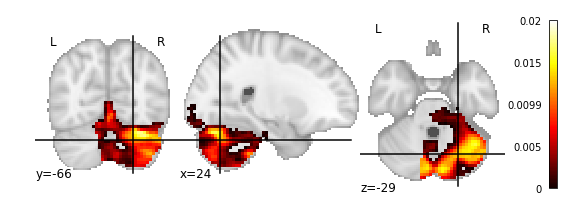

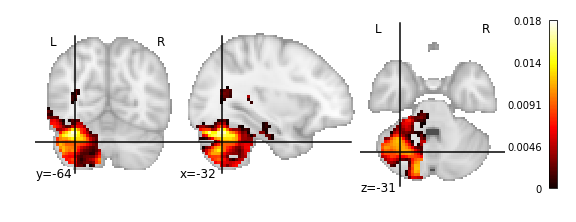

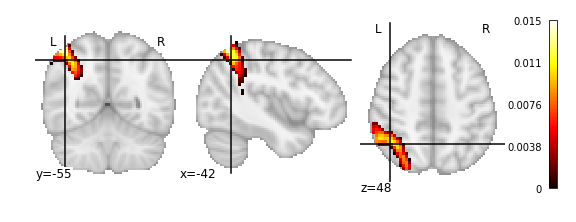

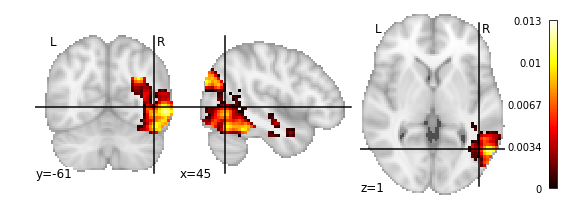

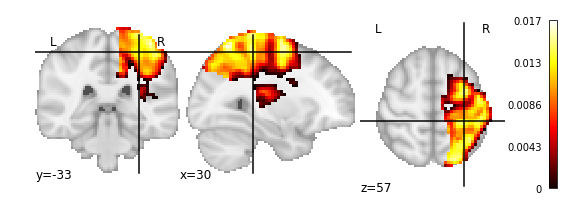

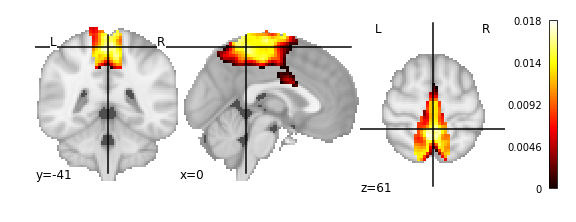

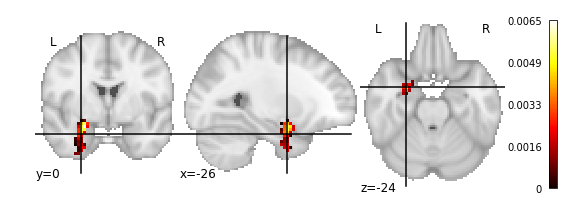

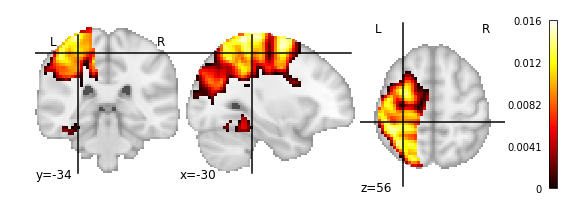

In [8]:
for region_img in image.iter_img(regions_extracted_img):
    plotting.plot_stat_map(region_img)

Compute correlation coefficients
---------------------------------



In [9]:
# First we need to do subjects timeseries signals extraction and then estimating
# correlation matrices on those signals.
# To extract timeseries signals, we call transform() from RegionExtractor object
# onto each subject functional data stored in func_filenames.
# To estimate correlation matrices we import connectome utilities from nilearn
from nilearn.connectome import ConnectivityMeasure

correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(func_filenames, confounds):
    # call transform from RegionExtractor object to extract timeseries signals
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    # call fit_transform from ConnectivityMeasure object
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    # saving each subject correlation to correlations
    correlations.append(correlation)

# Mean of all correlations
import numpy as np
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted,
                                                          n_regions_extracted)

Plot resulting connectomes
----------------------------



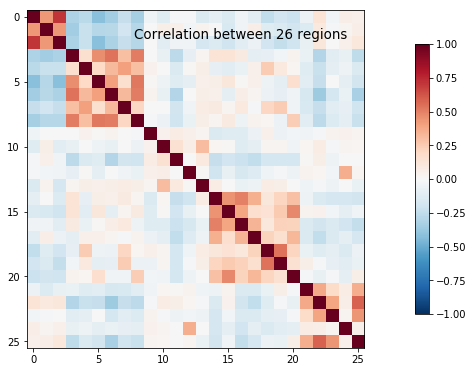

In [10]:
title = 'Correlation between %d regions' % n_regions_extracted

# First plot the matrix
display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1,
                               colorbar=True, title=title)

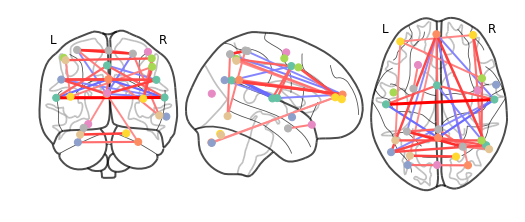

In [11]:
# Then find the center of the regions and plot a connectome
regions_img = regions_extracted_img
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='90%')

Interactive plotting

In [12]:
plotting.view_connectome(mean_correlations, coords=coords_connectome, threshold='80%')

Exercise
----------------

* Consider using an ICA (nilearn.decomposition.CanICA) instead of dictionary learning

* Try increasing the number of regions